<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/FFN/DUDL_FFN_weightHistograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

In [3]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Create train/test groups using DataLoader

In [4]:
# Step 1: Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

# Step 2: Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Step 3: Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Step 4: Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [5]:
def create_the_MNIST_net():
    """"
    FFN_WEIGHTHISTOGRAMS
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, loss_func, optimizer


Summary of model: 
mnist_net(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
) 

Summary of input layer: 
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0076, -0.0106,  0.0264,  ..., -0.0010,  0.0056, -0.0346],
        [ 0.0022, -0.0225, -0.0343,  ...,  0.0276,  0.0307, -0.0227],
        [-0.0082,  0.0028,  0.0153,  ..., -0.0288, -0.0116,  0.0311],
        ...,
        [ 0.0195,  0.0197, -0.0068,  ...,  0.0051,  0.0308,  0.0135],
        [ 0.0085, -0.0312, -0.0108,  ..., -0.0345, -0.0184, -0.0058],
        [ 0.0278, -0.0011,  0.0353,  ..., -0.0267,  0.0051,  0.0004]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.0229,  0.0031,  0.0093,  0.0079, -0.0343, -0.0102,  0.0125,  0.0197,
         0.0338, -0.0061,  0.0165, -0.024

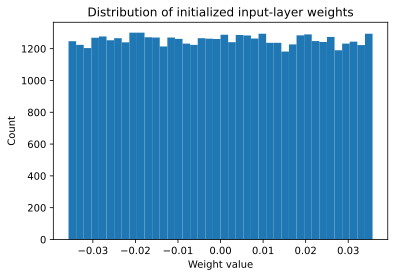

In [6]:
# EXPLORING THE "INNARDS" OF THE MODEL
# Create a temp model to explore
net = create_the_MNIST_net()[0]

# Summary of the entire model
print('Summary of model: ')
print(net, '\n')

# Explore one of the layers
print('Summary of input layer: ')
print(vars(net.input), '\n')

# Check out the matrix of weights
print('Input layer weights: ')
print(net.input.weight.shape)
print(net.input.weight, '\n')

# Finally, extract the weights and make a histogram
w = net.input.weight.detach().flatten()
plt.hist(w, 40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized input-layer weights')
plt.show()

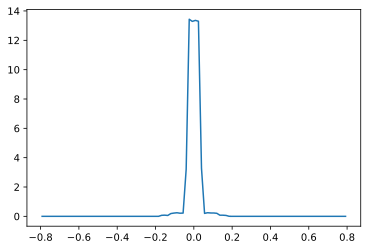

In [7]:
# FUNCTION RETURNING A HISTOGRAM OF ALL WEIGHTS (ACROSS ALL LAYERS)
def weights_histogram(net):

  # Initialize weight vector
  W = np.array([])

  # Concatenate each set of weights into 1 vector
  # Get weights of all the layers
  for layer in net.parameters():
    W = np.concatenate((W, layer.detach().flatten().numpy()))

  # Compute theri histogram (Range is hard-coded)
  # 100 bin between -0.8 & 0.8
  hist_y, hist_x = np.histogram(W, bins=np.linspace(-0.8, 0.8, 101), density=True)
  hist_x = (hist_x[1:] + hist_x[:-1]) / 2

  return hist_x, hist_y

# Test
hist_x, hist_y = weights_histogram(net)
plt.plot(hist_x, hist_y)

# Create a function that trains the model

In [8]:
def train_the_model():
    """
    FFN_WEIGHTHISTOGRAMS
    """
    
    num_epochs = 100

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_net()

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    test_acc  = []

    # Initialize histogram variables
    hist_x = np.zeros((num_epochs, 100))
    hist_y = np.zeros((num_epochs, 100))

    # Loop over epochs
    for epoch_i in range(num_epochs):
        # Get the weights distribution at the start of this epoch
        hist_x, hist_y[epoch_i, :] = weights_histogram(net)

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        with torch.no_grad(): # Deactivates autograd
          y_hat = net(X)

        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, test_acc, losses, net, hist_x, hist_y

# Run the model and show the results!

In [9]:
train_acc, test_acc, losses, net, hist_x, hist_y = train_the_model()


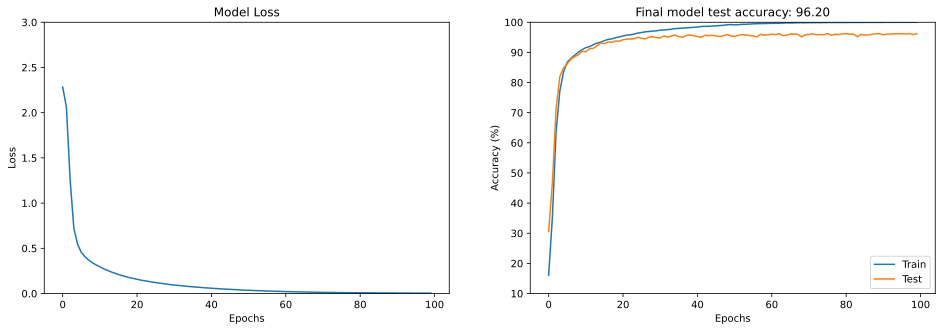

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,  label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}')
ax[1].legend()

plt.show()

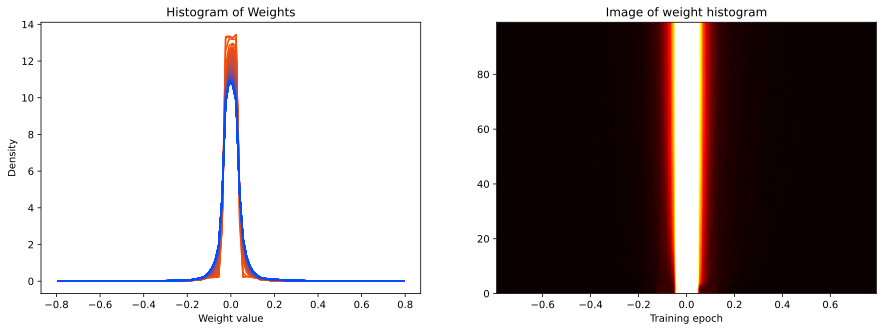

In [11]:
# SHOW THE HISTOGRAM OF THE WEIGHTS
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(hist_y.shape[0]):
  ax[0].plot(hist_x, hist_y[i, :], color=[1 - i / 100, 0.3, i / 100])

ax[0].set_title('Histogram of Weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')

ax[1].imshow(hist_y, vmin=0, vmax=3, extent=[hist_x[0], hist_x[-1], 0, 99],
             aspect='auto', origin='lower', cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_xlabel('Training epoch')
ax[1].set_title('Image of weight histogram')

plt.show()

# Additional explorations
1) Separate the distributions for input, hidden, and output layers. 
   Are the learning-related changes similar across all layers?

2) Re-run the code without data normalization. 
   Does the scale of the data affect the scale of the weights?

3) Test how dropout regularization affects the weight distributions.
